In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

from functools import partial
from itertools import product
import matplotlib.pyplot as plt
from scipy.optimize import Bounds
from adsorption_model import (
    LogThomasModelParameters,
    ThomasExperimentalSetup,
    Experiment,
    BreaktroughData,
)
from IPython.display import display_latex

plt.rcParams["axes.prop_cycle"] = plt.cycler(
    "color", ["#ffffcc", "#c2e699", "#78c679", "#31a354", "#006837"]
)

display_latex = partial(display_latex, raw=True)


In [2]:
data_path = Path(".data/scaling_pilot_and_small.ods")

setups = ("PILOT", "SMALL")
tnames = ("4min", "6min")
contaminants = ("PFOA", "PFHxA", "PFHxS", "BEZ", "DCF", "PFBA")

In [3]:
metadata = pd.read_excel(data_path, sheet_name="META", index_col="Parameter")
metadata

,PILOT 6min,PILOT 4min,SMALL 6min,SMALL 4min
Parameter,,,,
LENGTH (cm),3.81,2.54,1.28,0.85
POROSITY (-),0.40,0.40,0.40,0.40
DENSITY (g/L),1.00,1.00,1.00,1.00
DIAMETER COLUMN (cm),2.54,2.54,0.66,0.66
PARTICLE SIZE (µm),525.00,525.00,168.00,168.00


In [4]:
data = {}

for setup, tname in product(setups, tnames):
    which = f"{setup} {tname}"
    sheet_name = f"{which} Out"
    df = pd.read_excel(data_path, sheet_name=sheet_name)

    ## Read metadata for experiment
    length = metadata.loc["LENGTH (cm)", which]
    porosity = metadata.loc["POROSITY (-)", which]
    rho_p = metadata.loc["DENSITY (g/L)", which]
    diameter = metadata.loc["DIAMETER COLUMN (cm)", which]
    particle_size = metadata.loc["PARTICLE SIZE (µm)", which] / 10_000

    cross_area = 0.25 * np.pi * diameter**2  # cm²
    pore_velocity = (
        df["FLOW RATE (ml/min)"].mean()
        * 60  # cm³/h
        / (cross_area * porosity)
    )  # cm/h

    ## Assemble experiments for each contaminant
    df = df.dropna()

    experiments = []
    for contaminant in contaminants:
        exp = Experiment(
            name=f"{which} {contaminant}",
            contaminant=contaminant,
            setup=ThomasExperimentalSetup(
                C_0=1,  # µg/L
                length=length,  # cm
                pore_velocity=pore_velocity,  # cm/h
                rho_p=rho_p,  # g/L
                porosity=porosity,  # -
                particle_size=particle_size,  # cm
            ),
            parameters=LogThomasModelParameters(),
            btc=BreaktroughData(
                time=df["CUMUL TIME (h)"].to_numpy(),  # h
                conc=df[f"Rel. {contaminant}"].to_numpy(),  # µg/L
            ),
        )
        exp.dataframe = df
        experiments.append(exp)

    ## Save Experiment objects
    data[which] = experiments

In [5]:
data.keys()

dict_keys(['PILOT 4min', 'PILOT 6min', 'SMALL 4min', 'SMALL 6min'])

### Fitting parameters to all experiments

In [6]:
fit_bounds = Bounds(lb=[-6, -2, -1], ub=[1, 10, 5])

pilot_fit_config = dict(
    initial_guess=LogThomasModelParameters(log_k_T=-2.5, log_q_m=4, log_b=3),
    bounds=fit_bounds,
)

small_fit_config = dict(
    initial_guess=LogThomasModelParameters(log_k_T=0, log_q_m=2, log_b=1),
    bounds=fit_bounds,
)

for k, experiments in data.items():
    if "PILOT" in k:
        for exp in experiments:
            exp: Experiment = exp
            exp.fit(**pilot_fit_config)
    elif "SMALL" in k:
        for exp in experiments:
            exp: Experiment = exp
            exp.fit(**small_fit_config)

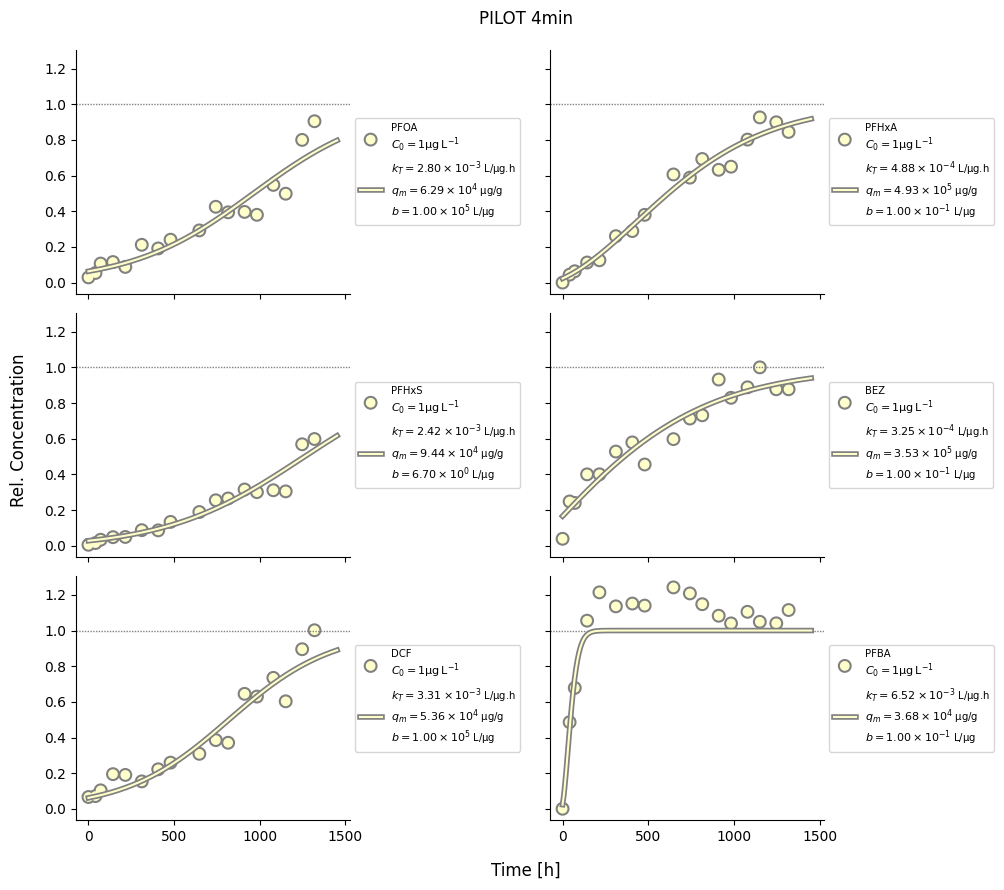

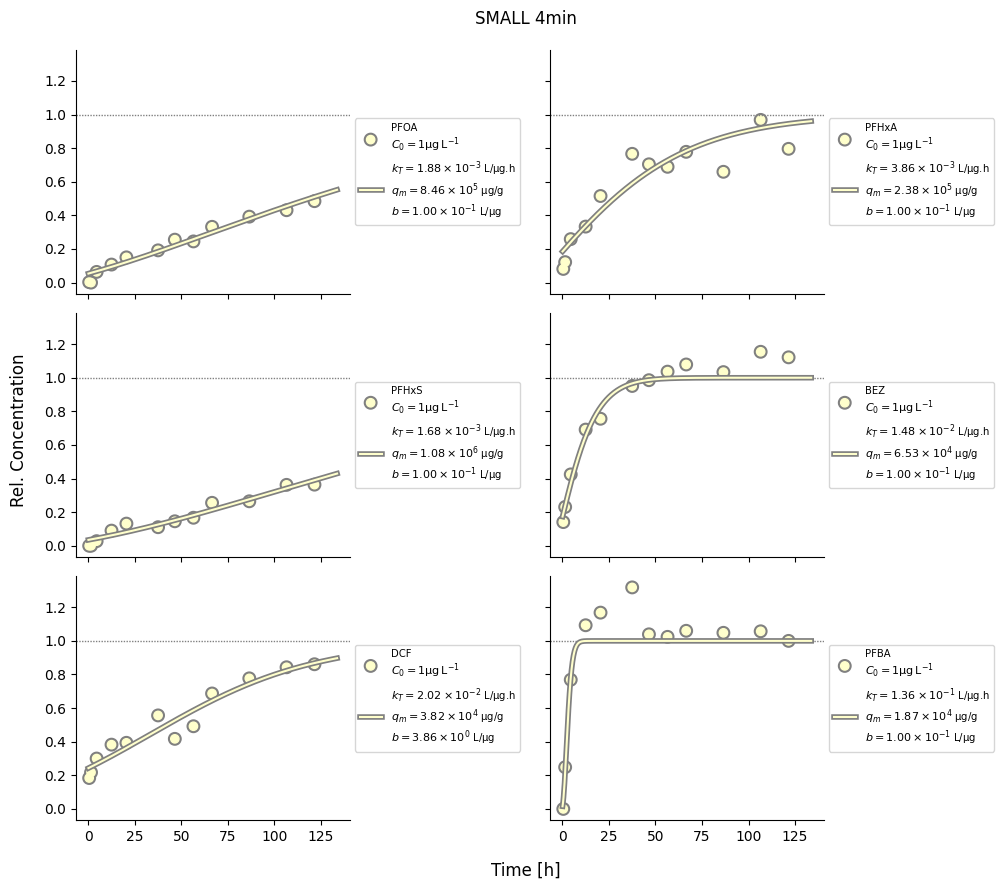

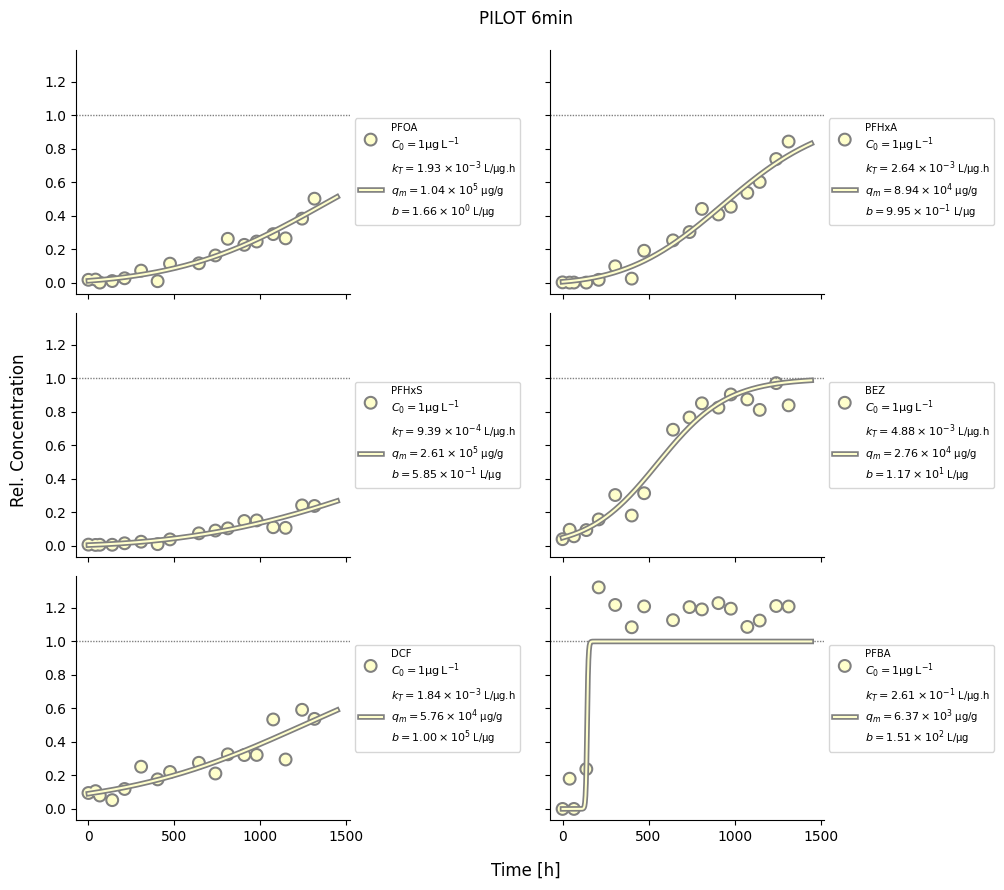

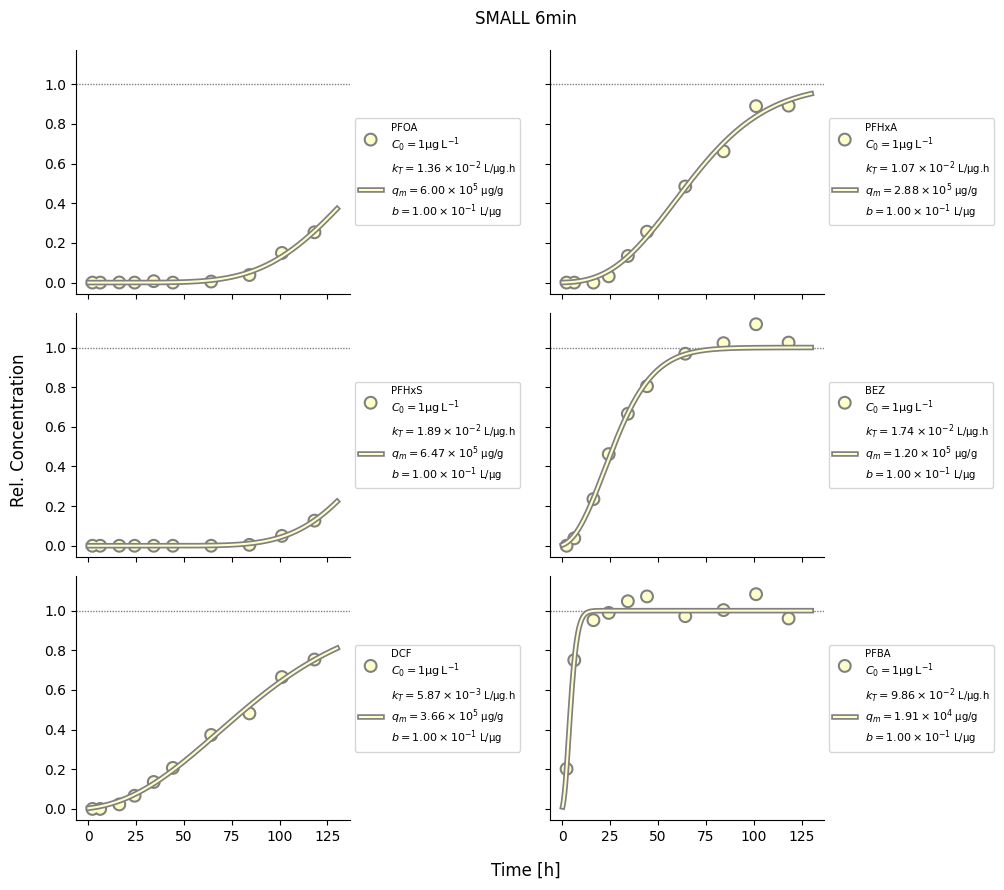

In [7]:
def plot_btcs_with_fit(title: str):
    exps: list[Experiment] = data[title]
    fig, axs = plt.subplots(
        len(exps) // 2,
        2,
        sharex=True,
        sharey=True,
        figsize=(12, 10),
        gridspec_kw={"hspace": 0.08, "wspace": 0.04},
    )
    for ax, exp in zip(axs.flatten(), exps):
        ax: plt.Axes
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])

        try:
            exp.plot_relative_btc(with_fit=True, ax=ax)
        except ValueError:
            ax.clear()
            exp.plot_relative_btc(ax=ax)

        ax.legend(
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            prop={"stretch": 100, "size": 8},
        )
        ax.spines.top.set_visible(False)
        ax.spines.right.set_visible(False)

    fig.supylabel("Rel. Concentration", x=0.07)
    fig.supxlabel("Time [h]", y=0.05)
    fig.suptitle(title, y=0.92)

    plt.show()


for t in ("PILOT 4min", "SMALL 4min", "PILOT 6min", "SMALL 6min"):
    plot_btcs_with_fit(t)

In [8]:
import pickle

with open(".data/experiments.pkl", "wb") as f:
    pickle.dump(data, f)